<a href="https://colab.research.google.com/github/cyuancheng/NLP_Yelp_review/blob/master/NLP_1_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Natural Language Processing and Sentiment Analysis for Twitter##


In [0]:
import spacy #use NLP functions
from spacy import displacy
from textblob import TextBlob
import tweepy #tweeter python package
import re
import en_core_web_sm #(python -m spacy download en_core_web_lg) # pre-train model sm: small
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

% matplotlib inline

###1. NLP###
Spacy

In [22]:
nlp = en_core_web_sm.load()  # spacy language model

doc1 = nlp(u'NJ Princeton Public Library is awesome. Enter https://princetonlibrary.org/')

for token in doc1: # parse each word and make token
    
    print(token.text) #Text: The original word text.
    #print(token.lemma) #Lemma: The base form of the word.
    #print(token.pos_) #POS: The simple part-of-speech tag.
    #print(token.tag_) #Tag: The detailed part-of-speech tag.
    #print(token.dep_) #Dep: Syntactic dependency, i.e. the relation between tokens.
    #print(token.shape_) #Shape: The word shape – capitalisation, punctuation, digits.
    #print(token.is_alpha) #is alpha: Is the token an alpha character?
    #print(token.is_stop) #is stop: Is the token part of a stop list, i.e. the most common words of the language?

NJ
Princeton
Public
Library
is
awesome
.
Enter
https://princetonlibrary.org/


In [0]:
displacy.render(doc1, style='ent',jupyter = True) #Visualizing the entity recognizer

In [28]:
text = """But Google is starting from behind. The company made a late push
into hardware, and Apple’s Siri, available on iPhones, and Amazon’s Alexa
software, which runs on its Echo and Dot devices, have clear leads in
consumer adoption."""

doc2 = nlp(text)
displacy.render(doc2, style='ent', jupyter=True)

In [30]:
displacy.render(doc1, style='dep',jupyter = True) #Spacy dependency visualizer

In [32]:
options = {'compact': True, 'bg': '#09a3d5',
           'color': 'white', 'font': 'Source Sans Pro'}
displacy.render(doc1, style='dep', jupyter = True, options=options)


In [33]:
token_exemple = doc1[0]
token_exemple

NJ

In [34]:
token_exemple.ent_type_

'ORG'

In [35]:
token_exemple.is_stop

False

In [36]:
[x for x in doc1 if x.text not in spacy.lang.en.stop_words.STOP_WORDS]


[NJ,
 Princeton,
 Public,
 Library,
 awesome,
 .,
 Enter,
 https://princetonlibrary.org/]

In [37]:
# print stop words
spacy.lang.en.stop_words.STOP_WORDS

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'front',
 'full',
 'further',
 'get',
 'give',
 'g

Add word into stop_work list

In [0]:
w = 'https'
nlp.vocab[w].is_stop = True

In [39]:
nlp('https')[0].is_stop

True

In [40]:
# print token
print(token_exemple.vector[:10])
len(token_exemple.vector)

[-1.3438694   2.2110689   2.960999    5.1636534   0.09328234  4.1673794
  1.0691484  -1.2223803   1.5614059   1.0312486 ]


384

In [41]:
doc3 = nlp('I am feeling blue')
doc4 = nlp('the sky is blue')
doc5 = nlp('I am sad')


print(doc2[-1].vector[0])
print(doc3[-1].vector[0]) 
print(doc4[-1].vector[0]) 

1.6701834
-1.049581
-1.1331878


In [42]:
len(doc2[-1].vector)

384

Similarity analysis



In [44]:
print('The similarity between doc 3 and doc 4 is {}'.format(doc3.similarity(doc4)))
print('The similarity between doc 4 and doc 5 is {}'.format(doc4.similarity(doc5)))



The similarity between doc 3 and doc 4 is 0.5246592405896248
The similarity between doc 4 and doc 5 is 0.4329018029459278


TextBlob vs Spacy sentiment analysis

In [45]:
print('Spacy\'s sentiment analysis result is {}'.format(doc5.sentiment))

print('TextBlob\'s sentiment analysis result is {}'.format(TextBlob('I am sad').sentiment))

Spacy's sentiment analysis result is 0.0
TextBlob's sentiment analysis result is Sentiment(polarity=-0.5, subjectivity=1.0)


The following functions are wrangling the data from tweeter

In [0]:
class connection_twitter():
    def __init__(self,consumer_key, consumer_secret, access_token, access_token_secret, keyword):
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        self.api = tweepy.API(auth)
        self.key_word = [keyword]

        return None


#%%
# Structure the tweets

    def get_info(self,tweet):
        id = tweet.id
        text_ = tweet.full_text
        author = tweet.author
        date = tweet.created_at
        location = tweet.coordinates
        favorite_count = tweet.favorite_count

        user_favorite_count = tweet.user.favourites_count
        user_followers_count = tweet.user.followers_count
        user_location = tweet.user.location

        return id, text_, author, date, location, favorite_count, user_favorite_count, user_followers_count, user_location


    def get_texts(self):

        all_results = []
        for i in range(len(self.key_word)):
            tweets = tweepy.Cursor(self.api.search, q=self.key_word, lang = "en",tweet_mode='extended').items(100)
            result = [tweet for tweet in tweets]
            all_results.append(result)

        for i in range(len(all_results)):
            if i == 0:
                tweet_data = pd.DataFrame([self.get_info(tweet) for tweet in all_results[i]])

            else:
                tweet_data = pd.concat([pd.DataFrame([self.get_info(tweet) for tweet in all_results[i]]), tweet_data])

        tweet_data.columns = ['id', 'text_', 'author', 'date', 'location', 'favorite_count', 'user_favorite_count', 'user_followers_count', 'user_location']

        return tweet_data


<h1>Twitter Analysis</h1>
<p>Now let's assess one public debate on twitter. The keyword we are going to use is "Wall"</p>

In [56]:
consumer_key = 'oxzQOYB3Yh1cTezTa0X9yYWaB'
consumer_secret = 'tL7HzTqiORDEvnzSq5ghsOwl9wl2ntlPT5Q8opdGMErltW1dr5'
access_token = '3579562937-XxUFCW12vuqHwjifqx0YTOAi8xzRKvIWPZsx5DV'
access_token_secret = '9b0WGTWIrSQZY7QAWtpXuZEkEKrKjKpKPcm70BFb9XrkD'
#keyword = 'harmony'
keyword = 'Colgate Total'

twitter = connection_twitter(consumer_key,consumer_secret,access_token,access_token_secret,keyword)

data = twitter.get_texts()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 9 columns):
id                      65 non-null int64
text_                   65 non-null object
author                  65 non-null object
date                    65 non-null datetime64[ns]
location                0 non-null object
favorite_count          65 non-null int64
user_favorite_count     65 non-null int64
user_followers_count    65 non-null int64
user_location           65 non-null object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 4.6+ KB


Sentiment analysis in the tex column using TextBlob

In [0]:
data['Polarity'] = [TextBlob(x).sentiment[0] for x in data['text_'] ]
data['Subjectivity'] = [TextBlob(x).sentiment[1] for x in data['text_'] ]

In [98]:
#https://developer.twitter.com/content/developer-twitter/en.html
data.head(5)
#len(data)

,id,text_,author,date,location,favorite_count,user_favorite_count,user_followers_count,user_location,Polarity,Subjectivity
0,1106057387855642624,Colgate total white with green tea mint https:...,User(_api=<tweepy.api.API object at 0x7f1586f1...,2019-03-14 05:00:05,None,0,3500,608,"Bogotá, D.C., Colombia",-0.066667,0.350
1,1106006253698981888,2 FREE Colgate Total Toothpastes at Walgreens ...,User(_api=<tweepy.api.API object at 0x7f1586f1...,2019-03-14 01:36:54,None,0,113,18147,,0.133333,0.550
2,1105997896644739072,FREE Colgate Total Toothpaste at CVS ~ {3/17 –...,User(_api=<tweepy.api.API object at 0x7f1586f1...,2019-03-14 01:03:41,None,0,0,145,"Houston, TX",0.200000,0.775
3,1105992917678768128,Colgate Total Mouthwash ONLY $.99 at CVS https...,User(_api=<tweepy.api.API object at 0x7f1586f1...,2019-03-14 00:43:54,None,0,222,57,"Florence, KY",0.000000,0.875
4,1105961866306772992,Free move fot the #animals BOL\n\n[307701] TOT...,User(_api=<tweepy.api.API object at 0x7f1586f1...,2019-03-13 22:40:31,None,3,304,6167,Philadelphia,0.200000,0.775


In [99]:
#data.groupby('user_location').sum().sort_values(["user_favorite_count", "user_followers_count"],ascending=False)
data1 = data.groupby('user_location').sum().sort_values(["Polarity"],ascending=False)
data1.head(5)

,id,favorite_count,user_favorite_count,user_followers_count,Polarity,Subjectivity
user_location,,,,,,
,1.656541e+19,13.0,155231.0,333549.0,1.684150,6.672845
United Kingdom,3.311948e+18,1.0,3966.0,45402.0,0.472527,1.892298
Malaysia,1.105150e+18,0.0,2892.0,502.0,0.341667,0.537500
America,1.102737e+18,1.0,57675.0,2240.0,0.309524,0.407143
"San Francisco, CA",1.105216e+18,1.0,131343.0,547.0,0.271429,0.421429


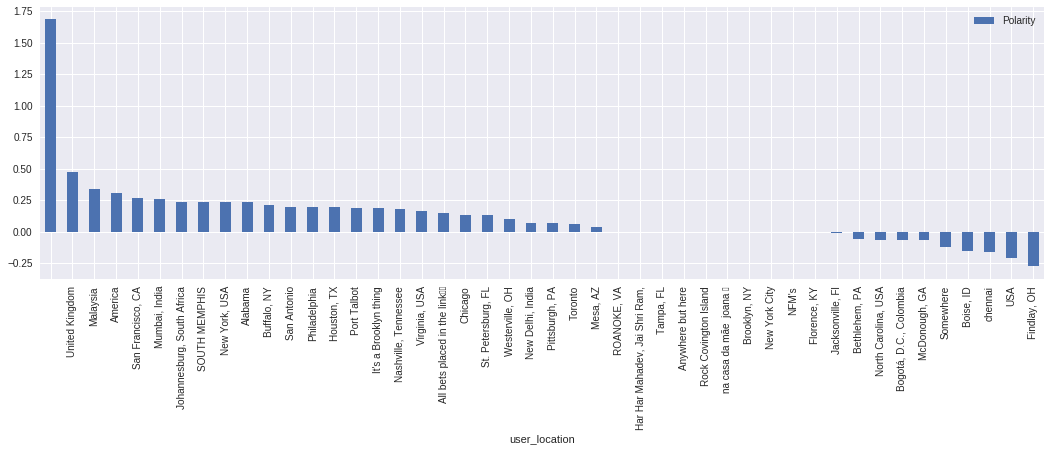

In [96]:
data1[['Polarity']].plot(kind='bar', figsize=(18, 5), legend=True)

In [97]:
#print(data['text_'][5])
#print(data['user_location'][5])
data.iloc[64,:]

id                                                    1102634649006809095
text_                   RT @WorldTruthTV: Colgate Total Toothpaste Has...
author                  User(_api=<tweepy.api.API object at 0x7f1586f1...
date                                                  2019-03-04 18:19:20
location                                                             None
favorite_count                                                          0
user_favorite_count                                                   996
user_followers_count                                                 2041
user_location                                               New York City
Polarity                                                                0
Subjectivity                                                         0.75
Name: 64, dtype: object

Try wordcloud

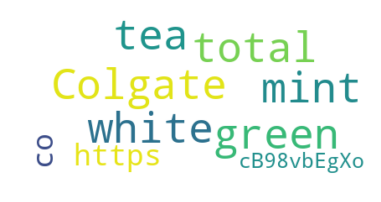

In [100]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(data['text_'][0])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


Print postive word by wordcloud

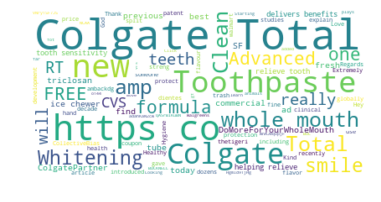

In [101]:
text_pro = ''
for text in data[data['Polarity']>0]['text_']:
  
  text_pro = text_pro + ' ' + text

#text_pro


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_pro)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
  
 

print negative words by wordcloud

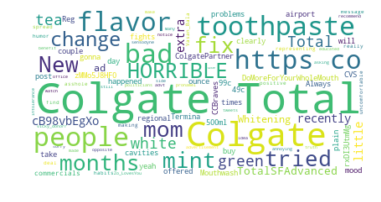

In [102]:
text_negative = ''
for text in data[data['Polarity']<0]['text_']:
  
  #if text not in spacy.lang.en.stop_words.STOP_WORDS:
  text_negative = text_negative + ' ' + text


text_negative

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_negative)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
  
 

In [0]:
# filter out the stop words and make new word cloud
def clean_text(text_series):
  nlp = en_core_web_sm.load()
  full_text = ''
  
  new_stop_words = ['RT','harmony']
  for word in new_stop_words:
    nlp.vocab[word].is_stop = True
  
  for text in text_series:
    text1 = nlp(text)
    
    for token in text1:
      if token.is_stop:
        pass
      else:
        full_text = full_text + ' ' + token.text

  return full_text


text_positive = clean_text(data[data['Sentiment']>0]['text_'])



In [0]:
text_negative

" RT @Viandrawsstuff: Bingpup, Lanbun, Huachungus. Long ago, the three gongs lived together in harmony. Then, everything changed when the Fir… RT @Viandrawsstuff: Bingpup, Lanbun, Huachungus. Long ago, the three gongs lived together in harmony. Then, everything changed when the Fir… RT @musicnewsfact: BLACKPINK joins TWICE as the ONLY girl groups in HISTORY to have at least 1 album certified Platinum (250,000) by Gaon!… RT @EsmanVlada: Working everyday is hollow when that paycheck isn't going to the one who gives you purpose, adopt a bill to find fulfillmen… https://t.co/wyDpuq3XF1 What do the Olympics and Compassionate Accountability have in common? https://t.co/3FwP7ZGoT9 RT @RalphCindrich: @DavidMTodd You're light on the locker room &amp; off-field conduct &amp; conduct in the game. Way too long to list here. And al… RT @oocbangtan: long ago, the four nations lived together in harmony. then, everything changed when the fire nation attacked https://t.co/m… @ferialexonar Oh nooo  my t

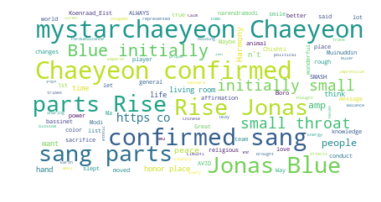

In [0]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_positive)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
  
